### imports

In [1]:
import os
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from zlib import crc32
import random
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### 1. Fetch data

In [2]:
"""
Fetch .csv data from directories.
"""

csv_path = os.path.join('data')
all_files = os.listdir(csv_path)
csv_files = [f for f in all_files if f.count('rent') == 1 and f.count('.csv') == 1] # if you want rent-apartments, set 1 instad 0
df_list = []

for csv in csv_files:
    file_path = os.path.join(csv_path, csv)
    try:
        # Try reading the file using default UTF-8 encoding
        df = pd.read_csv(file_path)
        df_list.append(df)
    except Exception as e:
        print(f"Could not read file {csv}, error: {e}")

data = pd.concat(df_list, ignore_index=True)

print(f"Samples amount: {len(data)}")
data.head()

Samples amount: 43305


id      city               type  \
0  2a1a6db97ff122d6bc148abb6f0e498a  szczecin       blockOfFlats   
1  5a0cb42c088eadf75aa98a4118640048  szczecin       blockOfFlats   
2  996722490efcb4b34d48bb84a9a72838  szczecin                NaN   
3  50d75c688530b9a61ba505301e0b94a9  szczecin  apartmentBuilding   
4  9b187f4203adabf466fd08610d8f4e5e  szczecin  apartmentBuilding   

   squareMeters  rooms  floor  floorCount  buildYear   latitude  longitude  \
0          52.0    2.0    3.0         3.0     2008.0  53.460535  14.545416   
1          57.0    3.0    NaN        10.0     1976.0  53.440955  14.566024   
2          43.4    2.0    3.0         4.0        NaN  53.435746  14.560764   
3          32.6    2.0    5.0         6.0     2021.0  53.421582  14.541572   
4          72.0    3.0    6.0         6.0     2014.0  53.450010  14.547230   

   ...  pharmacyDistance    ownership  buildingMaterial  condition  \
0  ...             0.307  condominium             brick        NaN   
1  ...             0.189  condominium               NaN    premium   
2  ...             0.211  condominium               NaN        NaN   
3  ...             0.192  condominium             brick    premium   
4  ...             0.315  condominium             brick    premium   

   hasParkingSpace  hasBalcony  hasElevator  hasSecurity  hasStorageRoom price  
0              yes         yes           no           no              no  3500  
1               no         yes          yes           no              no  3000  
2               no         yes           no           no              no  1900  
3               no         yes          yes           no              no  2500  
4               no         yes          yes           no             yes  2999  

[5 rows x 28 columns]

### 2. Data cleaning

In [3]:
"""
Check data type.
"""

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43305 entries, 0 to 43304
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    43305 non-null  object 
 1   city                  43305 non-null  object 
 2   type                  32595 non-null  object 
 3   squareMeters          43305 non-null  float64
 4   rooms                 43305 non-null  float64
 5   floor                 37970 non-null  float64
 6   floorCount            42399 non-null  float64
 7   buildYear             30814 non-null  float64
 8   latitude              43305 non-null  float64
 9   longitude             43305 non-null  float64
 10  centreDistance        43305 non-null  float64
 11  poiCount              43305 non-null  float64
 12  schoolDistance        43294 non-null  float64
 13  clinicDistance        43274 non-null  float64
 14  postOfficeDistance    43286 non-null  float64
 15  kindergartenDistanc

In [4]:
"""
Clean NaN and duplicates. Drop columns with lack of data.
"""

dropped_columns = ['id','type', 'floor', 'buildYear', 'condition', 'buildingMaterial']
data.drop(dropped_columns, axis=1, inplace=True)
data.dropna(inplace=True)
data = data.drop_duplicates().reset_index(drop=True)

In [5]:
"""
Check number of null values.
"""

print(f"Dataset amount: {len(data)}")
data.isna().sum()

Dataset amount: 23290


city                    0
squareMeters            0
rooms                   0
floorCount              0
latitude                0
longitude               0
centreDistance          0
poiCount                0
schoolDistance          0
clinicDistance          0
postOfficeDistance      0
kindergartenDistance    0
restaurantDistance      0
collegeDistance         0
pharmacyDistance        0
ownership               0
hasParkingSpace         0
hasBalcony              0
hasElevator             0
hasSecurity             0
hasStorageRoom          0
price                   0
dtype: int64

### 3. Analize cleared data

In [6]:
"""
Statistics.
"""

data.describe()

squareMeters         rooms    floorCount      latitude     longitude  \
count  23290.000000  23290.000000  23290.000000  23290.000000  23290.000000   
mean      54.108121      2.355217      5.807986     51.775312     19.636897   
std       21.321799      0.838352      3.522447      1.221669      1.671151   
min       25.000000      1.000000      1.000000     49.984500     14.468420   
25%       40.000000      2.000000      4.000000     51.060806     18.606012   
50%       49.220000      2.000000      5.000000     52.183068     19.952032   
75%       62.007500      3.000000      7.000000     52.252178     20.997603   
max      150.000000      6.000000     29.000000     54.571300     23.199087   

       centreDistance      poiCount  schoolDistance  clinicDistance  \
count    23290.000000  23290.000000    23290.000000    23290.000000   
mean         3.854090     24.139244        0.362612        0.761371   
std          2.524074     25.679261        0.303889        0.688861   
min          0.020000      0.000000        0.002000        0.001000   
25%          1.820000      9.000000        0.176000        0.302000   
50%          3.440000     16.000000        0.287000        0.560000   
75%          5.410000     29.000000        0.451750        0.964000   
max         16.400000    210.000000        4.109000        4.912000   

       postOfficeDistance  kindergartenDistance  restaurantDistance  \
count        23290.000000          23290.000000        23290.000000   
mean             0.460855              0.315003            0.252086   
std              0.341836              0.276337            0.273687   
min              0.001000              0.001000            0.001000   
25%              0.238000              0.151000            0.089000   
50%              0.391000              0.258000            0.184000   
75%              0.581000              0.397000            0.327000   
max              4.128000              4.231000            4.210000   

       collegeDistance  pharmacyDistance         price  
count     23290.000000      23290.000000  23290.000000  
mean          1.320834          0.299335   3741.364448  
std           1.025702          0.281773   2209.128507  
min           0.004000          0.001000    780.000000  
25%           0.545000          0.136000   2500.000000  
50%           1.010000          0.233000   3000.000000  
75%           1.857000          0.381000   4246.000000  
max           5.000000          4.198000  23000.000000

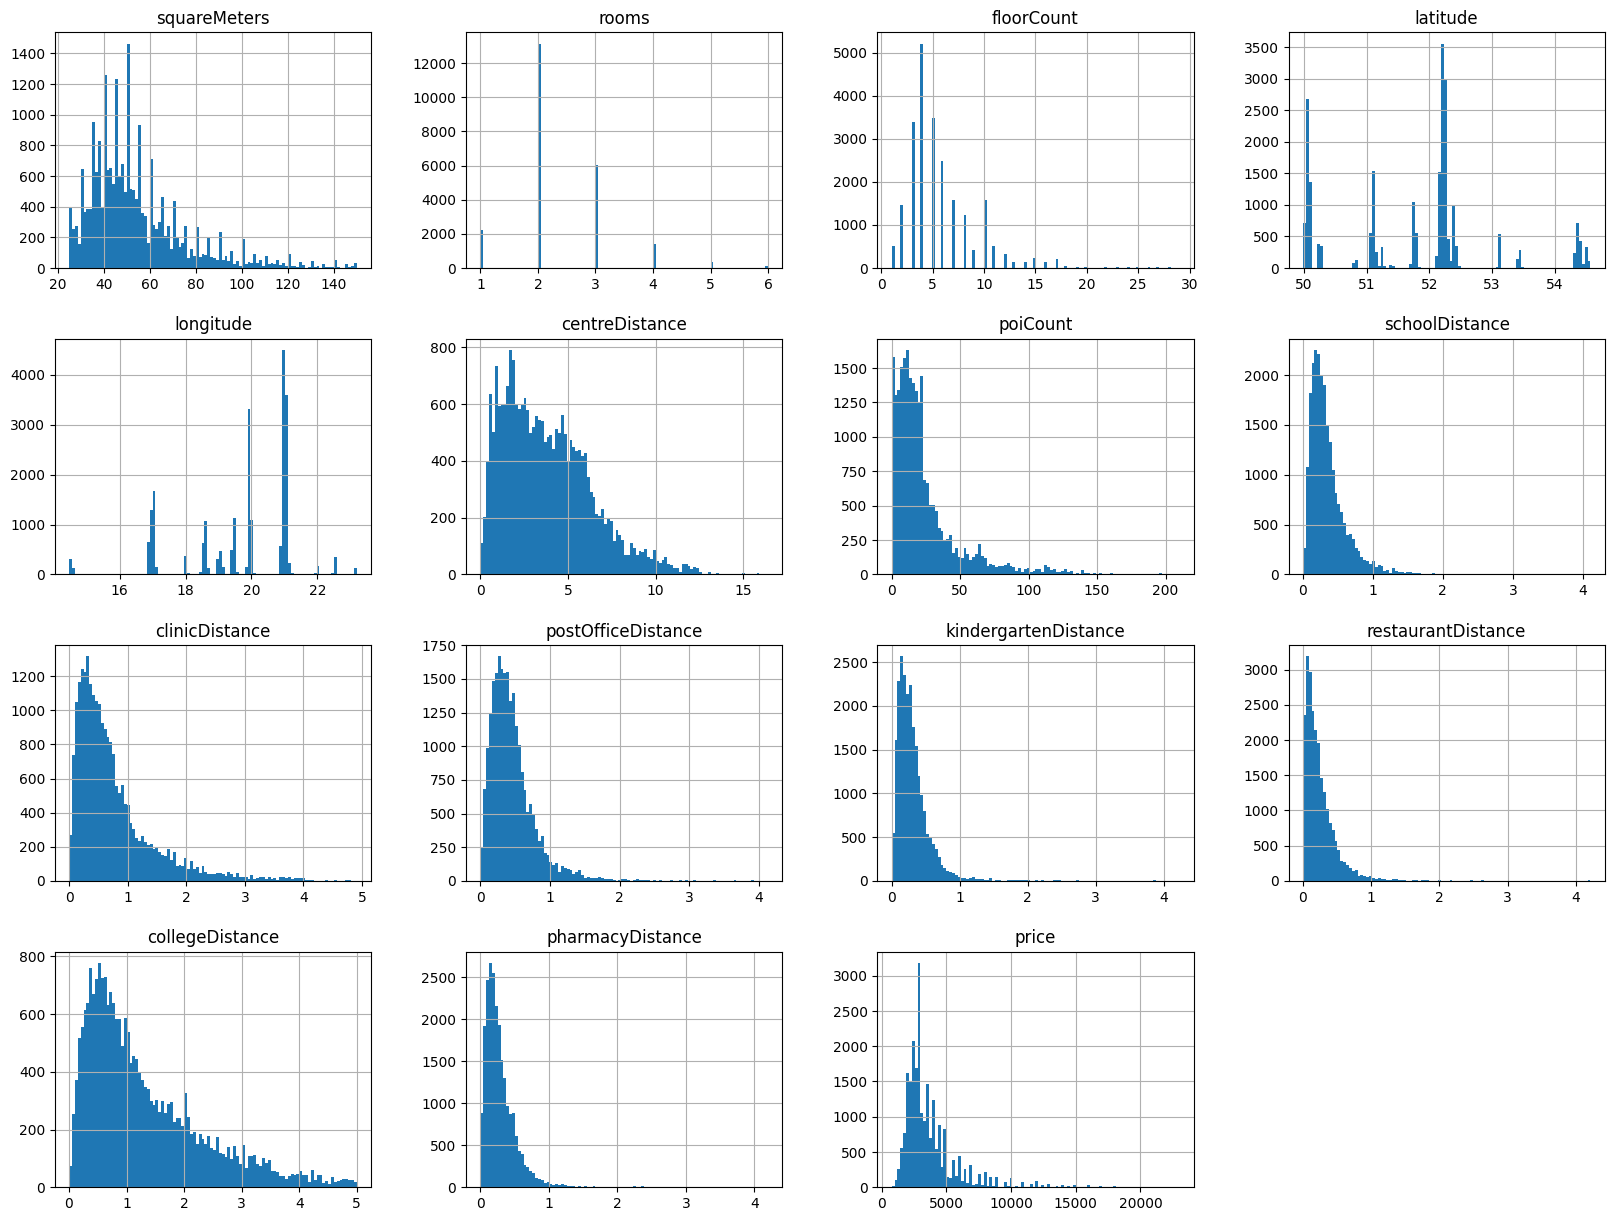

In [7]:
"""
Histograms.
"""

%matplotlib inline
data.hist(bins=100, figsize=(20,15))
plt.show()

In [8]:
"""
Locations on map.
This kind of map is loading quite long, but I think its worth it.
"""

locations = list(zip(data['latitude'], data['longitude']))
m = folium.Map(
    location=[np.mean(data['latitude']), np.mean(data['longitude'])],
    zoom_start=6
)
 
marker_cluster = MarkerCluster(locations=locations)
marker_cluster.add_to(m)
m

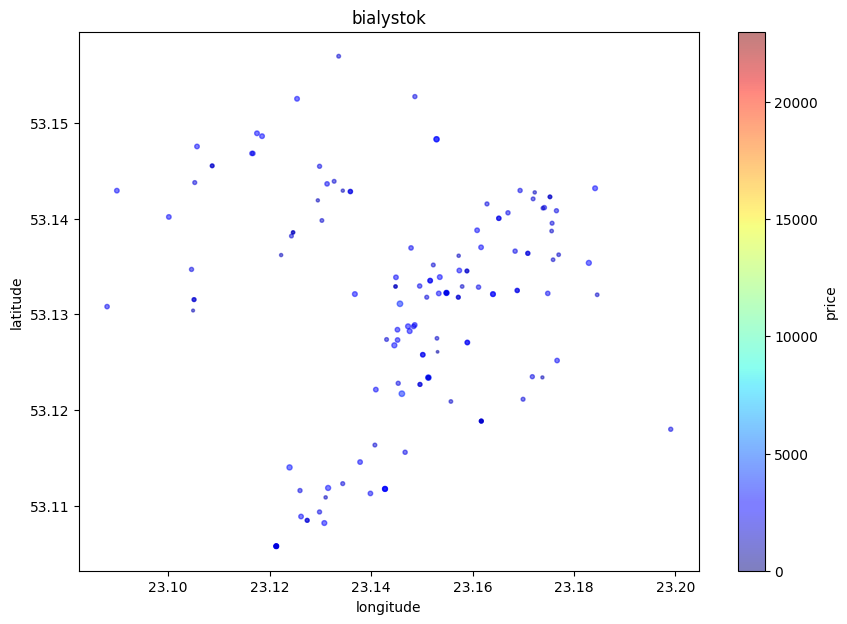

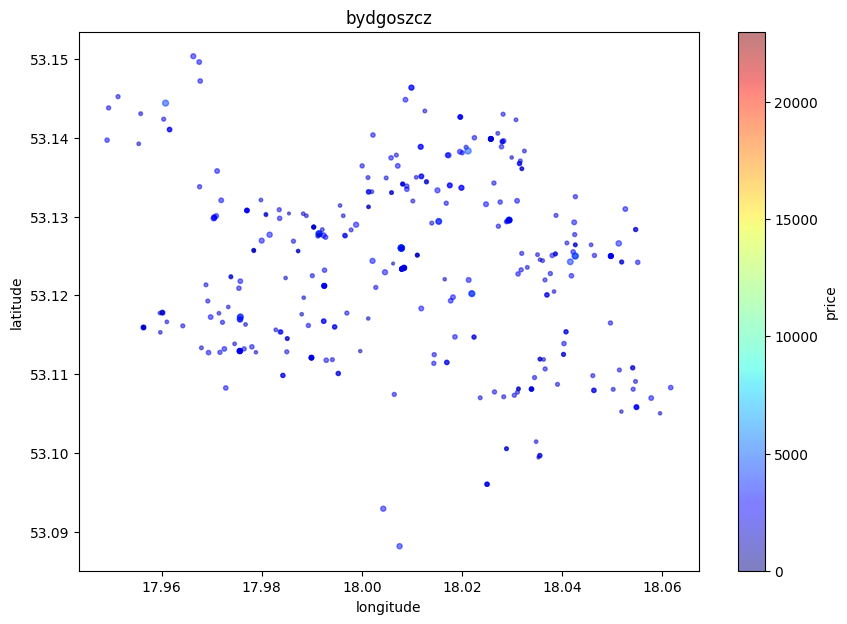

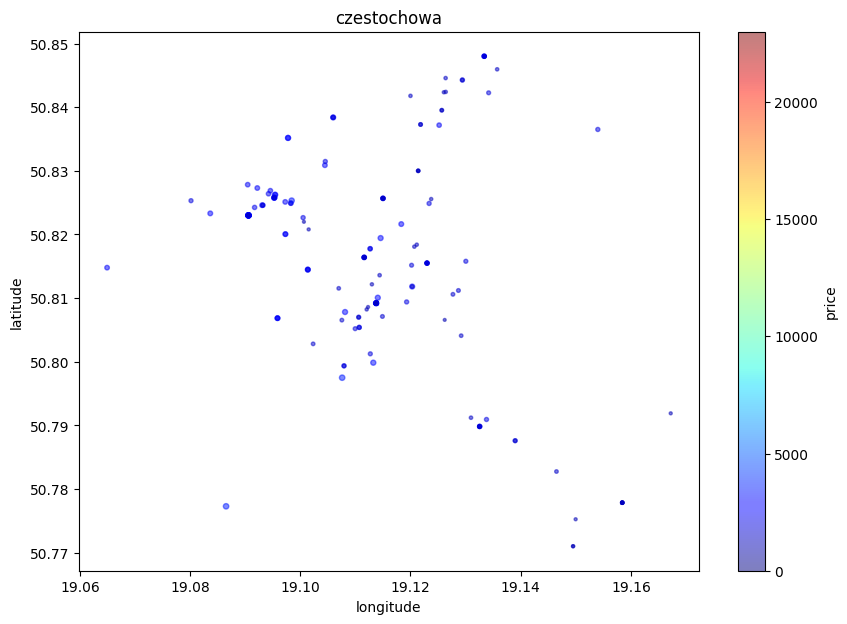

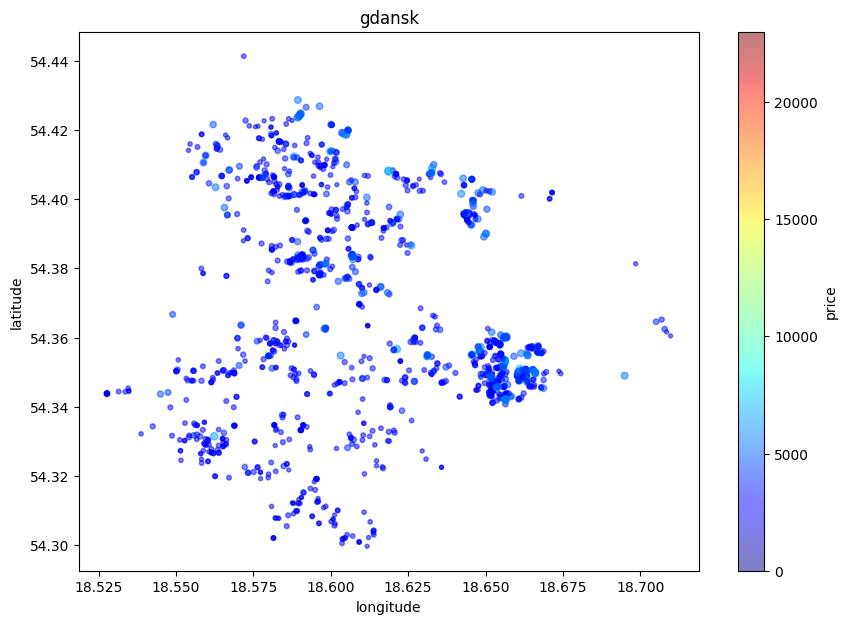

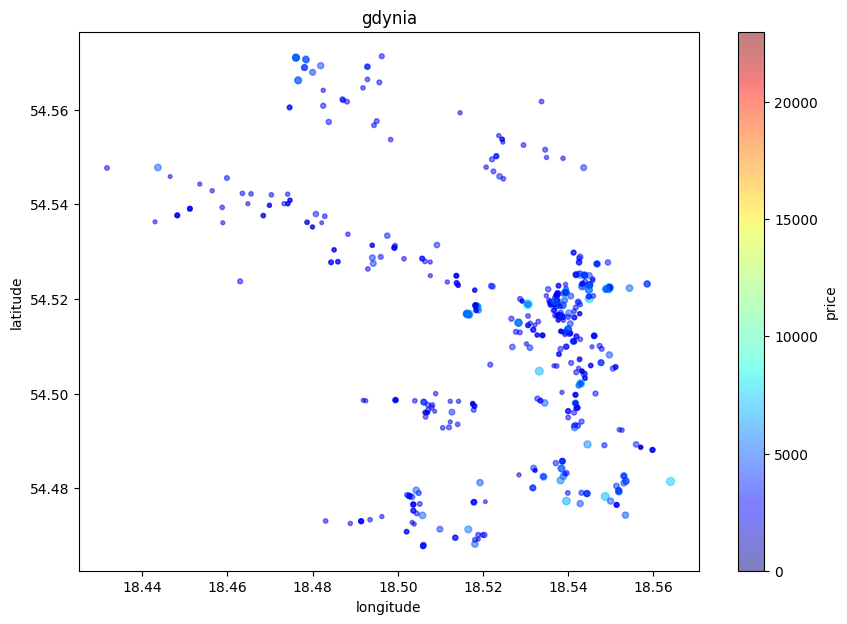

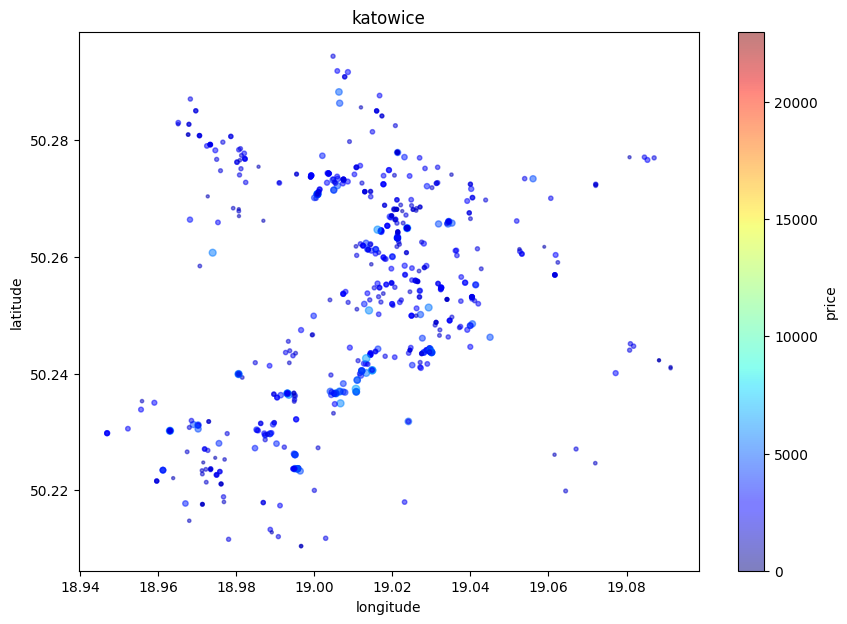

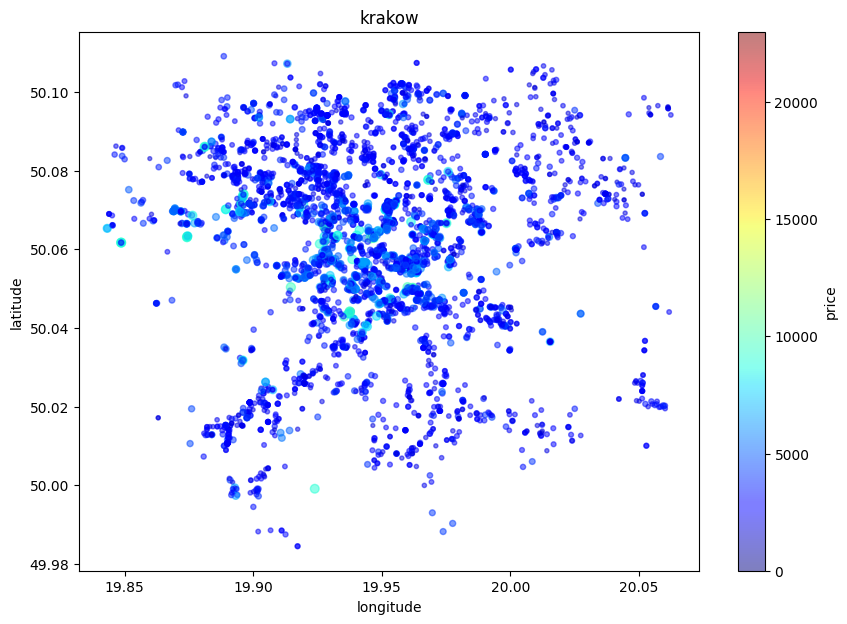

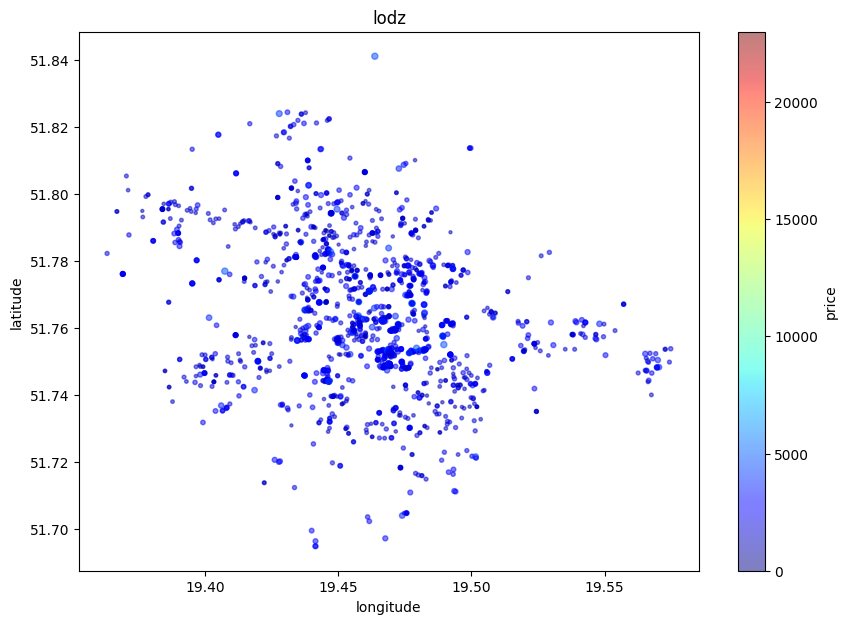

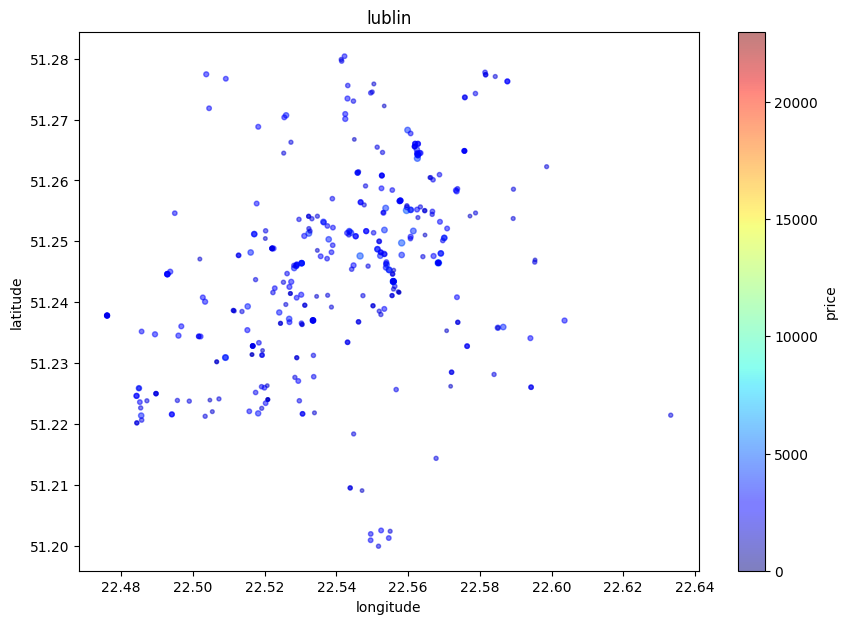

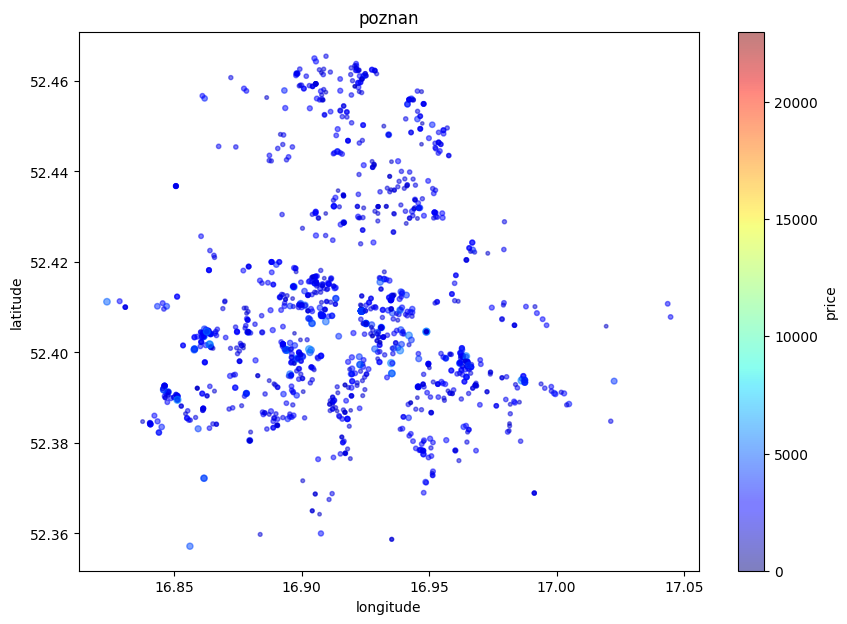

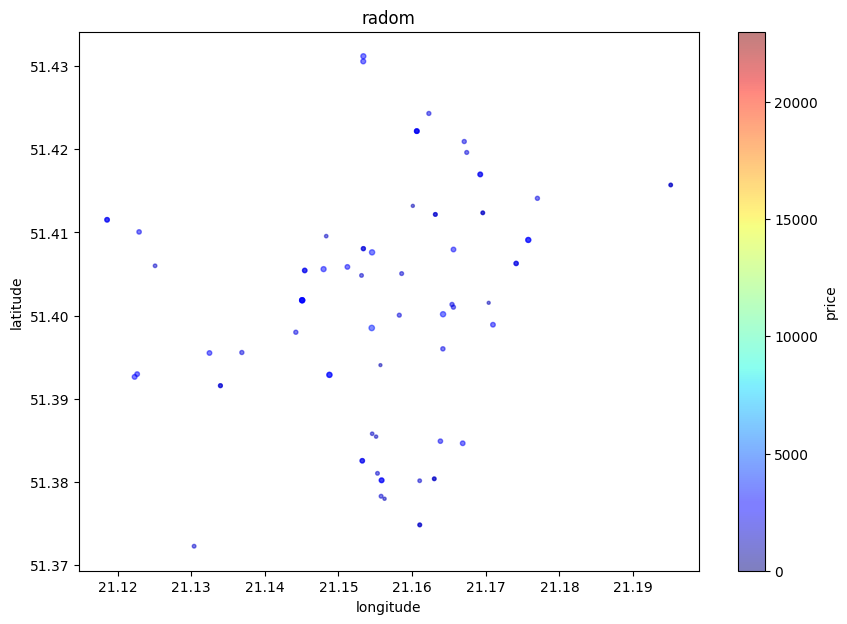

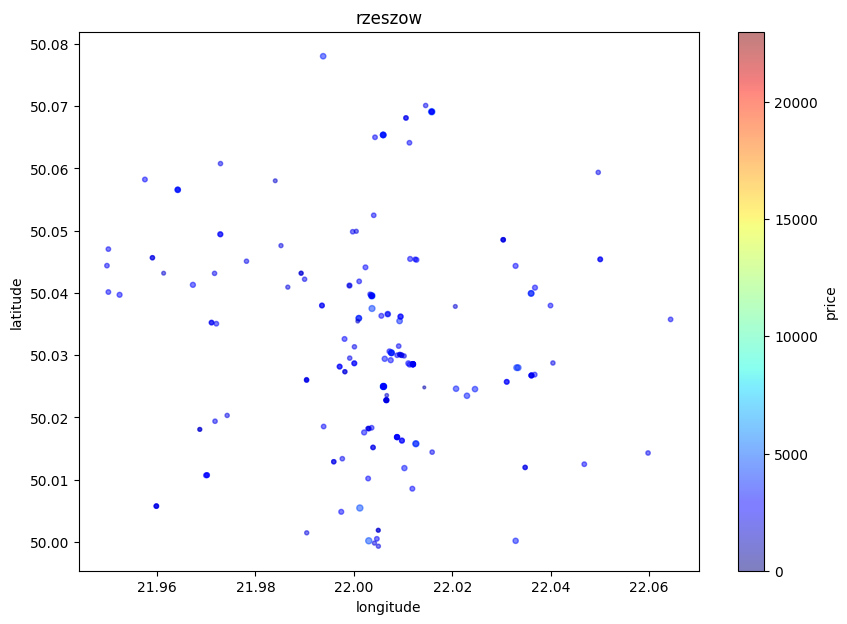

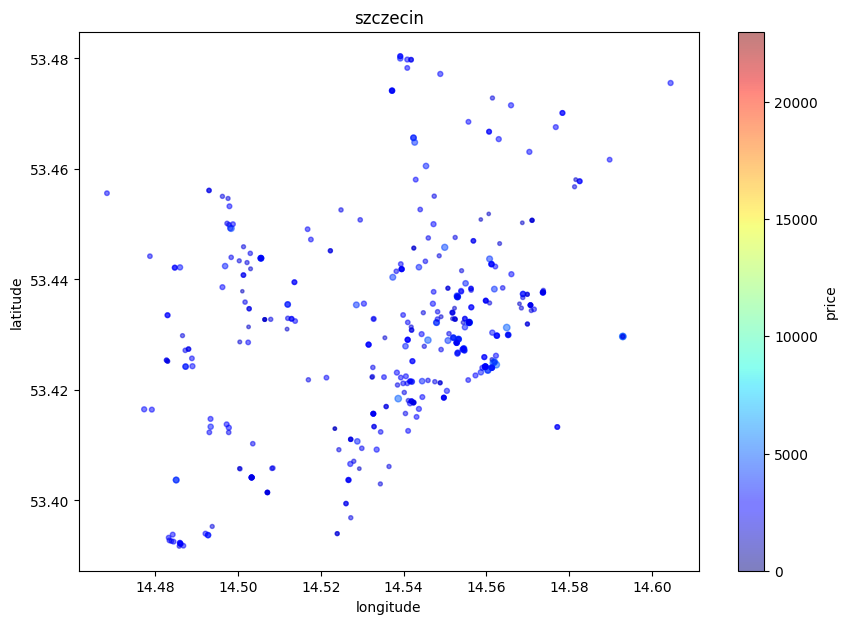

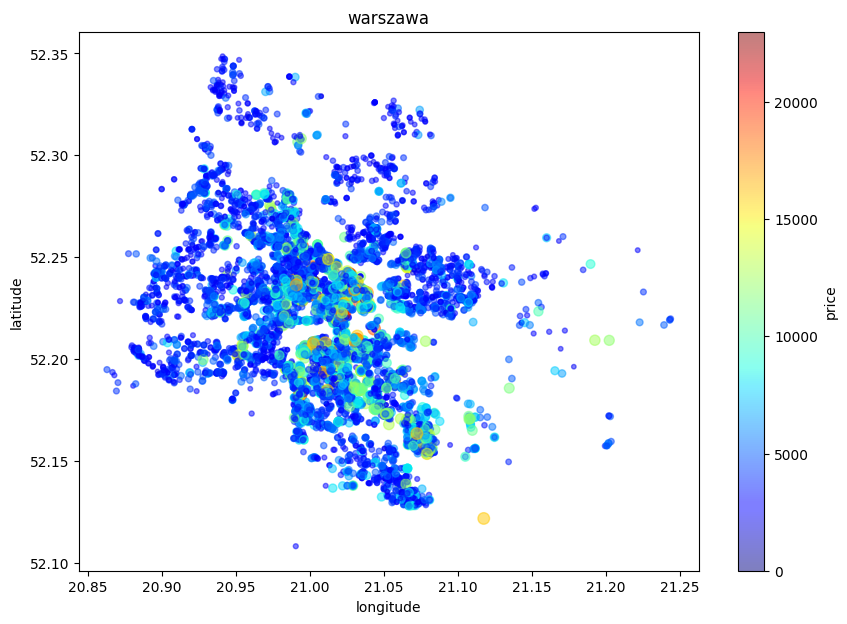

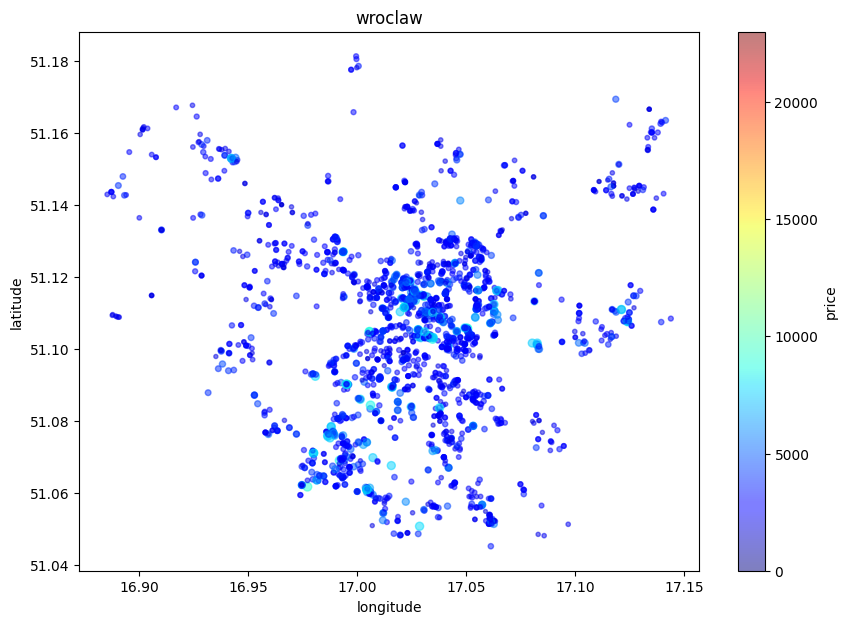

In [9]:
"""
Locations based on price.
"""

cities = np.unique(data['city'])
max_price = max(data['price'])
norm = Normalize(vmin=0, vmax=max_price)

for city in cities:
    subset = data[data['city'] == city]
    subset.plot(
        kind='scatter',
        x='longitude',
        y='latitude',
        title=city,
        alpha=0.5,
        s=100 * subset['price'] / max_price,
        figsize=(10, 7),
        c='price',
        norm=norm,
        cmap=plt.get_cmap('jet'),
        colorbar=True
    )

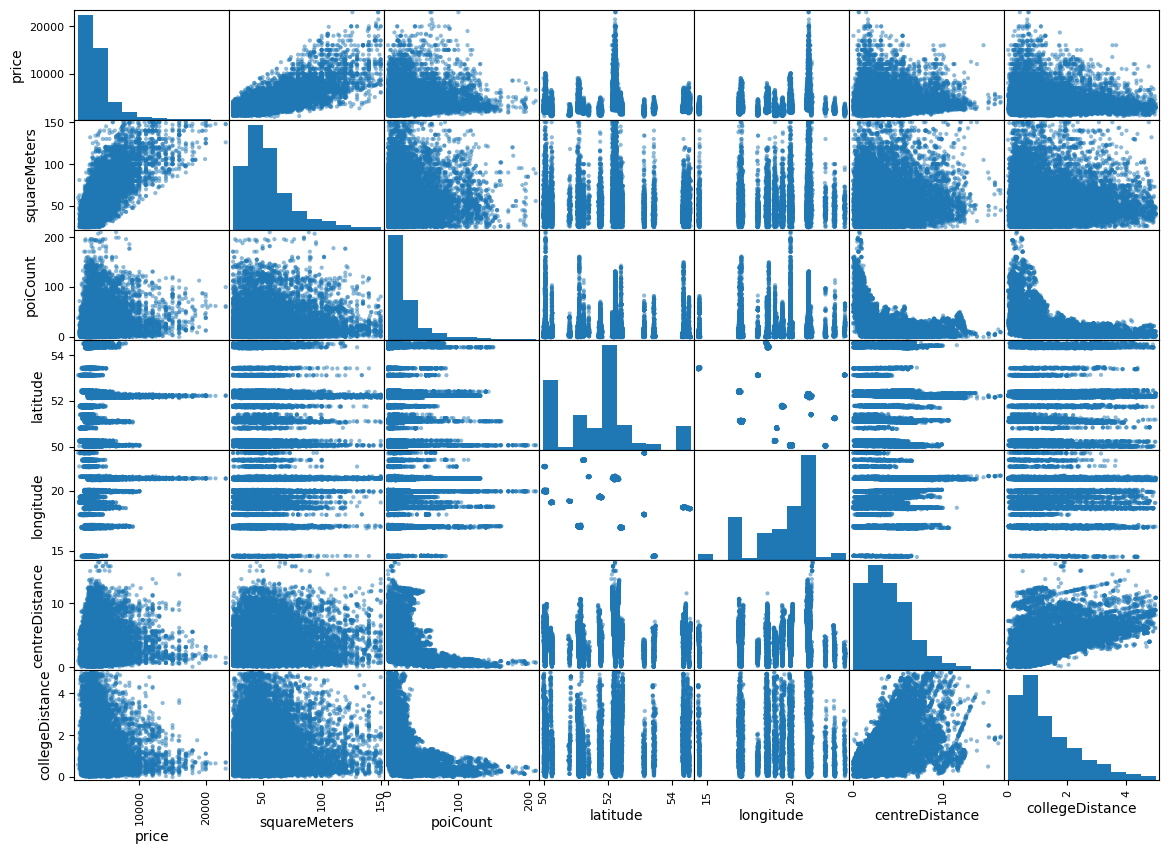

In [10]:
"""
Corelation matrix.
"""

%matplotlib inline
from pandas.plotting import scatter_matrix

attributes = ['price', 'squareMeters', 'poiCount', 'latitude', 'longitude', 'centreDistance', 'collegeDistance']
scatter_matrix(data[attributes], figsize=(14,10))
plt.show()

<AxesSubplot:>

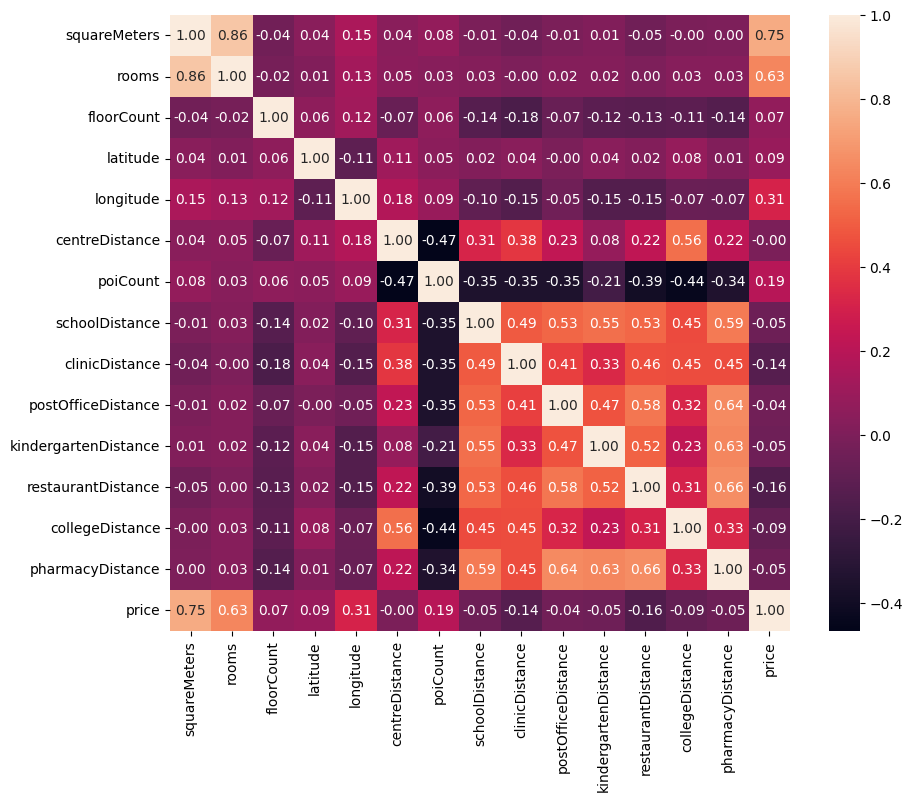

In [11]:
"""
Heatmap.
"""

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt = '.2f')

### 4. Split and build data

In [12]:
"""
One-hot coding for cities.
"""

city_dummies = pd.get_dummies(data['city'])
data = data.drop('city', axis=1)
data = pd.concat([data, city_dummies], axis=1)

In [13]:
"""
Normalization and exclude numerical columns.
"""

scaler = MinMaxScaler()
numerical_columns = data.select_dtypes(include=['number']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
data = data[numerical_columns]

In [14]:
"""
Split data to train and test.
"""

test_ratio = 0.1 # 10% of amount is test data
y = data['price']
X = data.drop(columns=['price'])
rand_val = random.randint(0, 111)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rand_val)

print(f"Training set amount: {len(X_train)}\nTest set amount: {len(X_test)}")



Training set amount: 20961
Test set amount: 2329


In [15]:
"""
Check columns and data example.
"""

X_train.head()

squareMeters  rooms  floorCount  latitude  longitude  centreDistance  \
17715       0.10400    0.2    0.357143  0.483139   0.744589        0.253968   
14441       0.31200    0.4    0.107143  0.958119   0.472619        0.310134   
11680       0.20000    0.2    0.142857  0.530583   0.274336        0.305250   
10419       0.06464    0.0    0.107143  0.494434   0.747523        0.143468   
11953       0.07200    0.2    0.000000  0.958577   0.484508        0.277167   

       poiCount  schoolDistance  clinicDistance  postOfficeDistance  ...  \
17715  0.061905        0.062820        0.105681            0.173492  ...   
14441  0.114286        0.037740        0.054164            0.071238  ...   
11680  0.000000        0.169467        0.161881            0.289072  ...   
10419  0.285714        0.019235        0.047648            0.022292  ...   
11953  0.000000        0.575116        0.739157            0.593652  ...   

       katowice  krakow  lodz  lublin  poznan  radom  rzeszow  szczecin  \
17715       0.0     0.0   0.0     0.0     0.0    0.0      0.0       0.0   
14441       0.0     0.0   0.0     0.0     0.0    0.0      0.0       0.0   
11680       0.0     0.0   0.0     0.0     1.0    0.0      0.0       0.0   
10419       0.0     0.0   0.0     0.0     0.0    0.0      0.0       0.0   
11953       0.0     0.0   0.0     0.0     0.0    0.0      0.0       0.0   

       warszawa  wroclaw  
17715       1.0      0.0  
14441       0.0      0.0  
11680       0.0      0.0  
10419       1.0      0.0  
11953       0.0      0.0  

[5 rows x 29 columns]

### 5. Build models


R^2 factor: 0.867


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

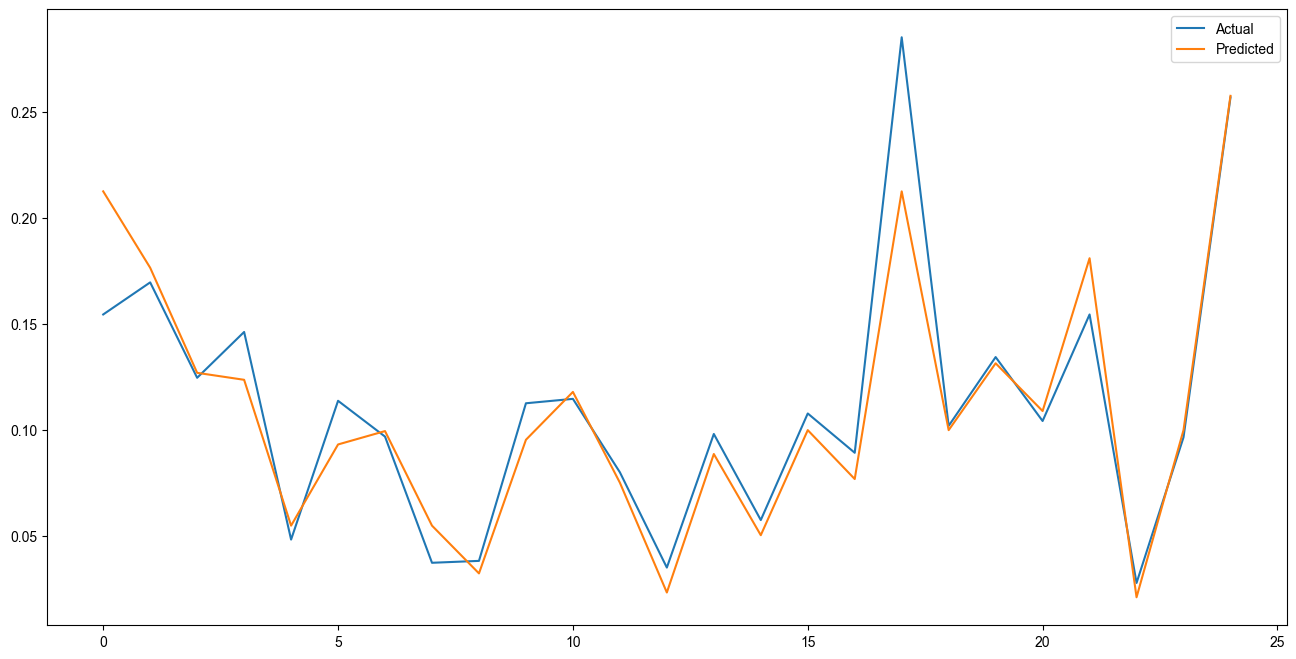

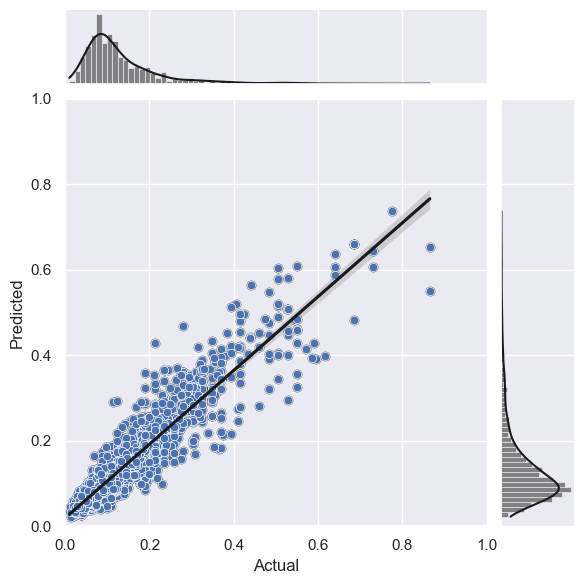

In [16]:
"""
Random forest regressor for every attribute (reg_14f)
""" 

# Find best model hiperparameters.
# parameters={
#     'max_depth':list(np.arange(5, 10, step=5)),
#     'n_estimators':np.arange(5, 10, step=5),
#     'criterion':['poisson','squared_error'],
#     'min_samples_split':np.arange(2, 10, step=2)
# }

# rf_reg = RandomForestRegressor()
# reg = RandomizedSearchCV(
#     estimator=rf_reg,
#     param_distributions=parameters,
#     n_iter=8,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )
# reg.fit(X_train, y_train)
# print("Best hiperparameters: " + str(reg.best_params_))
# print("Lowest MSE: "+ "{:.2f}".format(reg.best_score_))
# reg_14f = RandomForestRegressor(**reg.best_params_)


reg_14f = RandomForestRegressor()
reg_14f.fit(X_train, y_train)
y_pred = reg_14f.predict(X_test)
print("\nR^2 factor: " + "{:.3f}".format(r2_score(y_test, y_pred)))

y_diff = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig = plt.figure(figsize=(16,8))
y_diff = y_diff.reset_index()
y_diff = y_diff.drop(['index'],axis=1)
plt.plot(y_diff[:25])
plt.legend(['Actual','Predicted'])
sns.set(style='darkgrid')
jplot = sns.jointplot(
    xlim=(0,1.0),
    ylim=(0, 1.0),
    x='Actual',
    y='Predicted',
    data=y_diff,
    kind='reg',
    color='k'
);
sns.scatterplot(
    data=y_diff,
    x='Actual',
    y='Predicted',
    ax=jplot.ax_joint,
)

### 6. Export model to PMML

In [ ]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml

pipeline = PMMLPipeline([("estimator", reg_14f)])
sklearn2pmml(pipeline, "reg_14f.pmml", with_repr=True)